# DistilBert-uncased
https://huggingface.co/distilbert/distilbert-base-uncased


In [101]:
!nvidia-smi

Tue Mar  4 13:38:38 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.216.03             Driver Version: 535.216.03   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       On  | 00000000:B5:00.0 Off |                    0 |
| N/A   56C    P0              30W /  70W |   2719MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [102]:
%pip install transformers 
%pip install datasets 
%pip install torch 
%pip install scikit-learn
%pip install pandas
%pip install seaborn
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [103]:
import logging

# prepare logger
logging.basicConfig(level=logging.INFO)

transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

In [104]:
import torch
import pandas as pd
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, get_linear_schedule_with_warmup
from torch.utils.data import DataLoader, Dataset
import torch.optim as optim
import ast
import numpy as np
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from typing import Dict, Any, List
from datetime import datetime
import pickle
import seaborn as sns

In [105]:
MODEL_DIR = "models"
raw_dir = f"{MODEL_DIR}/raw"
basic_finetuned_dir = f"{MODEL_DIR}/basic_finetuned"
weighted_loss_dir = f"{MODEL_DIR}/weighted_loss"
weighted_sampler_dir = f"{MODEL_DIR}/weighted_sampler"
weighted_loss_sampler_dir = f"{MODEL_DIR}/weighted_loss_sampler"
augmented_dir = f"{MODEL_DIR}/augmented"
combined_dir = f"{MODEL_DIR}/combined"

In [106]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Load DistilBert-base-uncased


In [107]:
# Load tokenizer and model
MODEL_NAME = "distilbert-base-uncased"
tokenizer = DistilBertTokenizer.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(MODEL_NAME, num_labels=2) 

model.to(device)
model.save_pretrained(raw_dir)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


### Load raw text data

In [108]:
def convert_to_binary(label: Any) -> int:
    """
    Paragraphs with original labels of 0 or 1 are considered to be negative examples of PCL and will have the label 0 = negative.
		Paragraphs with original labels of 2, 3 or 4 are considered to be positive examples of PCL and will have the label 1 = positive.
    """
    # If label_array is a string, convert it to a list
    return 0 if label == 0 or label == 1 else 1 

In [109]:
TRAIN_DATA_PATH = "data/dontpatronizeme_pcl.tsv"
TRAIN_ALLOC_PATH = "data/train_semeval_parids-labels.csv"
DEV_ALLOC_PATH = "data/dev_semeval_parids-labels.csv"

column_names = ["par_id", "art_id", "keyword", "country", "text", "orig_label"]
text_data = pd.read_csv(TRAIN_DATA_PATH, sep="\t", header=None, names=column_names)
text_data["label"] = text_data["orig_label"].apply(convert_to_binary)

print("Text Data shape:", text_data.shape)

train_alloc = pd.read_csv(TRAIN_ALLOC_PATH).drop("label", axis=1)
official_dev_alloc = pd.read_csv(DEV_ALLOC_PATH).drop("label", axis=1)
print("Train Allocation shape:", train_alloc.shape)
print("Official Dev Allocation shape:", official_dev_alloc.shape)

train_data = pd.merge(train_alloc, text_data, on="par_id")
official_dev_data = pd.merge(official_dev_alloc, text_data, on="par_id")
print("Merged Train Data shape:", train_data.shape)
print("Merged Official Dev Data shape:", official_dev_data.shape)

Text Data shape: (10469, 7)
Train Allocation shape: (8375, 1)
Official Dev Allocation shape: (2094, 1)
Merged Train Data shape: (8375, 7)
Merged Official Dev Data shape: (2094, 7)


In [110]:
# Step 1: Identify rows with NaN in the 'text' column
nan_rows = official_dev_data[official_dev_data["text"].isna()]

# Step 2: Print the rows with NaN values
print("Rows with NaN values in 'text' column:")
print(nan_rows)

# Step 3: Remove rows with NaN values from the original official_dev_data
# official_dev_data = official_dev_data.dropna(subset=["text"])

# Step 3 alternative: replace with placeholder string
official_dev_data["text"] = official_dev_data["text"].fillna("missing text")

# Optionally, print the cleaned data shape
print("Cleaned Official Dev Data shape:", official_dev_data.shape)

Rows with NaN values in 'text' column:
     par_id      art_id  keyword country text  orig_label  label
434    8640  @@16852855  migrant      ke  NaN           0      0
Cleaned Official Dev Data shape: (2094, 7)


### (Pre-)Tokenize Dataset

In [111]:
def tokenize(text, tokenizer, max_length=128):
  return tokenizer(
    str(text),
    add_special_tokens=True,
    max_length=max_length,
    truncation=True,
    padding="max_length",
    return_tensors="pt"
  )

In [112]:
pretokenized_data = []
for index, row in train_data.iterrows():
  tokenized = tokenize(row["text"], tokenizer)
  tokenized = { key : value.squeeze(0).clone() for key, value in tokenized.items() }
  tokenized["labels"] = row["label"]
  tokenized["text"] = row["text"]
  pretokenized_data.append(tokenized)

with open("pretokenized.pkl", "wb") as f:
  pickle.dump(pretokenized_data, f)

### Load into DataLoader's

In [113]:
class DontPatronizeMeDataset(Dataset):
  def __init__(self, data, tokenizer = None, max_length=128):
    self.tokenizer = tokenizer

    if self.tokenizer is not None:
      self.max_length = max_length
      self.data = data.reset_index(drop = True)
    else:
      self.data = data

  def __len__(self) -> int:
    return len(self.data)

  def __getitem__(self, idx: int) -> Dict[str, torch.Tensor]:
    if self.tokenizer is not None:
      text = str(self.data.loc[idx, "text"])
      label = self.data.loc[idx, "label"]

      encoding = self.tokenizer(
        text, 
        add_special_tokens=True,
        max_length=self.max_length,
        padding="max_length",
        truncation=True,
        return_tensors="pt"
      )

      encoding = { key: value.squeeze(0) for key, value in encoding.items() }
      encoding["labels"] = torch.tensor(label, dtype=torch.long)

      return encoding
    else:
      return self.data[idx]


In [114]:
with open("pretokenized.pkl", "rb") as f:
  pretokenized_data = pickle.load(f)

labels = [int(item["labels"]) for item in pretokenized_data]

internal_train_data, internal_test_data = train_test_split(
  pretokenized_data,
  test_size = 0.2,
  random_state = 16,
  stratify=labels
)

train_dataset = DontPatronizeMeDataset(internal_train_data)
test_dataset = DontPatronizeMeDataset(internal_test_data)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

### Define evaluation/prediciton loops

In [115]:
def predict(model, loader: DataLoader, save_path: str = None):
  model.eval()

  predictions = []

  with torch.no_grad():
    for batch in loader:
      inputs = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      outputs = model(inputs, attention_mask=attention_mask)
      logits = outputs.logits

      preds = torch.argmax(logits, dim=1)
      predictions.extend(preds.cpu().numpy().tolist())
  
  if save_path is not None:
    with open(save_path, "w") as f:
      for prediction in predictions:
        f.write(f"{prediction}\n")

  return predictions

In [116]:
def evaluate(model, loader: DataLoader, plot_confusion: bool = False):
  y_true = []
  y_pred = []

  model.eval()
  with torch.no_grad():
      for batch in loader:
          inputs = batch["input_ids"].to(device)
          attention_mask = batch["attention_mask"].to(device)
          labels = batch["labels"].to(device)

          outputs = model(inputs, attention_mask=attention_mask)
          logits = outputs.logits

          predictions = torch.argmax(logits, dim=1)

          y_true.extend(labels.cpu().numpy().tolist())
          y_pred.extend(predictions.cpu().numpy().tolist())

  # # Convert to numpy arrays
  y_true = np.array(y_true)
  y_pred = np.array(y_pred)

  accuracy = accuracy_score(y_true, y_pred)
  f1 = f1_score(y_true, y_pred)

  # predictions, labels = predict(model, loader=loader, with_labels=True, save_path=save_path)


  return accuracy, f1

### Baseline Evaluation

In [117]:
model = DistilBertForSequenceClassification.from_pretrained(raw_dir).to(device)

# approx 1min
test_acc, test_f1 = evaluate(model, test_loader)

print("Pre trained")
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

Pre trained
Test Accuracy: 0.189851
Test F1 Score: 0.165950


### Define training loop

In [118]:
import matplotlib.pyplot as plt

def plot_losses(train_losses, val_losses, title = ""):
  epochs = list(range(1, len(train_losses) + 1))
  fig, ax1 = plt.subplots(figsize=(8, 6))

  color_train = 'tab:blue'
  ax1.set_xlabel('Epoch')
  ax1.set_ylabel('Training Loss', color=color_train)
  ax1.plot(epochs, train_losses, color=color_train, marker='o', label='Training Loss')
  ax1.tick_params(axis='y', labelcolor=color_train)

  # Create a second y-axis for the validation loss
  ax2 = ax1.twinx()
  color_val = 'tab:red'
  ax2.set_ylabel('Validation Loss', color=color_val)
  ax2.plot(epochs, val_losses, color=color_val, marker='o', label='Validation Loss')
  ax2.tick_params(axis='y', labelcolor=color_val)

  plt.title(title)
  fig.tight_layout()  # Adjust layout to ensure everything fits nicely
  plt.show()

In [119]:
from torch.amp import autocast, GradScaler

def finetune(
  model, 
  loader: DataLoader, 
  num_epochs: int = 5, 
  lr: float = 2e-5, 
  patience: int = 2,
  plot: bool = True,
  plot_title: str = "",
  loss_function = None
):

  best_val_loss = float("inf")
  epochs_no_improv = 0

  optimiser = optim.AdamW(model.parameters(), lr=lr)
  total_steps = len(loader) * num_epochs
  scheduler = get_linear_schedule_with_warmup(
    optimiser, 
    num_warmup_steps=0, 
    num_training_steps=total_steps
  )

  train_losses = []
  val_losses = []

  scaler = GradScaler(device="cuda")

  timestamp = datetime.now().strftime("%H:%M:%S")
  print(f"{timestamp} - num_epochs = {num_epochs} | lr = {lr} | patience = {patience}")

  for epoch in range(num_epochs):
    model.train()
    total_loss: float = 0.0

    for batch in loader:
      optimiser.zero_grad()

      inputs = batch["input_ids"].to(device)
      attention_mask = batch["attention_mask"].to(device)
      labels = batch["labels"].to(device)

      # Use `autocast` for mixed precision forward pass
      with autocast(device_type="cuda"):
        outputs = model(inputs, attention_mask=attention_mask, labels=labels)
        if loss_function is None:
          loss = outputs.loss
        else:
          logits = outputs.logits
          loss = loss_function(logits, labels)

      scaler.scale(loss).backward()
      scaler.step(optimiser)
      scheduler.step()
      scaler.update()

      total_loss += loss.item()

    avg_loss = total_loss / len(loader)
    train_losses.append(avg_loss)

    model.eval()
    total_val_loss = 0.0
    with torch.no_grad():
      for batch in loader:
        inputs = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        with autocast(device_type="cuda"):
          outputs = model(inputs, attention_mask=attention_mask, labels=labels)
          loss = outputs.loss
        total_val_loss += loss.item()

    avg_val_loss = total_val_loss / len(loader)
    val_losses.append(avg_val_loss)

    timestamp = datetime.now().strftime("%H:%M:%S")
    print(f"{timestamp} - Epoch {epoch + 1}/{num_epochs} | Train Loss: {avg_loss:.6f} | Validation Loss: {avg_val_loss:.6f}")

    if avg_val_loss < best_val_loss:
      best_val_loss = avg_val_loss
      epochs_no_improv = 0
      best_model_state = model.state_dict()

    else:
      epochs_no_improv += 1
      if epochs_no_improv >= patience:
        print(f"Stopping at epoch {epoch}...")
        break
    
  model.load_state_dict(best_model_state)

  if plot:
    plot_losses(train_losses, val_losses, title=plot_title)
    

### Baseline Finetune

13:39:12 - num_epochs = 4 | lr = 2e-05 | patience = 2


13:39:45 - Epoch 1/4 | Train Loss: 0.259236 | Validation Loss: 0.172214
13:40:18 - Epoch 2/4 | Train Loss: 0.153169 | Validation Loss: 0.073269
13:40:52 - Epoch 3/4 | Train Loss: 0.073398 | Validation Loss: 0.024668
13:41:27 - Epoch 4/4 | Train Loss: 0.029355 | Validation Loss: 0.013889


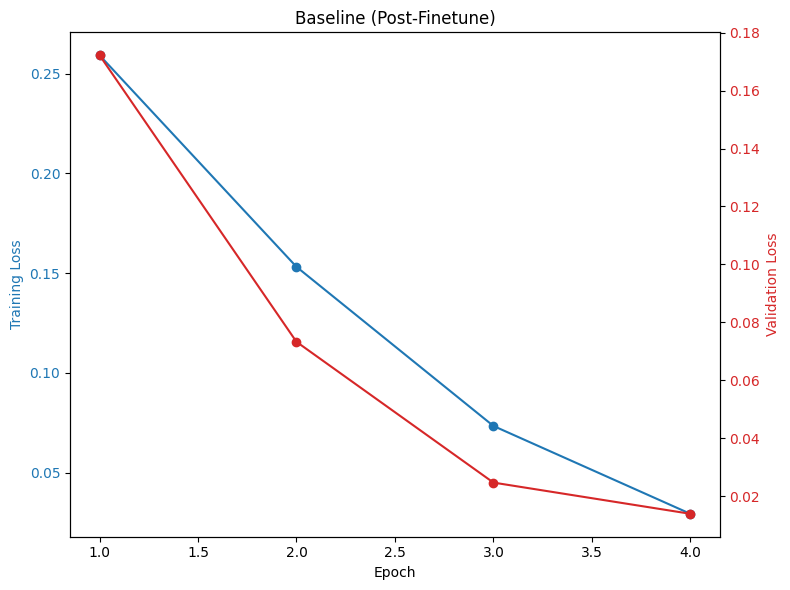

Post trained
Test Accuracy: 0.915821
Test F1 Score: 0.467925


In [120]:
torch.cuda.empty_cache()

model = DistilBertForSequenceClassification.from_pretrained(raw_dir).to(device)

# approx 5min per epoch
finetune(model, train_loader, num_epochs =4, plot_title="Baseline (Post-Finetune)")

# approx 1min
test_acc, test_f1 = evaluate(model, test_loader)

print("Post trained")
print(f"Test Accuracy: {test_acc:.6f}")
print(f"Test F1 Score: {test_f1:.6f}")

model.save_pretrained(basic_finetuned_dir)

### Evaluate on the dev set

In [121]:
full_dev_dataset = DontPatronizeMeDataset(official_dev_data, tokenizer, max_length=128)
full_dev_loader = DataLoader(full_dev_dataset, batch_size=16, shuffle=False, num_workers=4)

# approx 1min
test_acc, test_f1 = evaluate(model, full_dev_loader)

print("Dev set")
print(f"Accuracy: {test_acc:.6f}")
print(f"F1 Score: {test_f1:.6f}")

Dev set
Accuracy: 0.916428
F1 Score: 0.501425
